In [ ]:
!pip install -q pyvi scikit-learn transformers torch accelerate seaborn tqdm

import json
import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from pyvi import ViTokenizer
import shutil
# Check GPU
if torch.cuda.device_count() > 1:
    print(f"Running on Multi-GPU: {torch.cuda.device_count()} devices")
    BATCH_SIZE = 32
else:
    print("Running on Single GPU or CPU")
    BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Schema Valid
IGNORED_LABELS = {'PER_VICTIMPACT', 'CAUSES', 'CONSEQUENCES'}
VALID_SCHEMA = {
    'LOCATED_AT': [('EVENT', 'LOC')],
    'HAPPENED_ON': [('EVENT', 'TIME')],
    'INVOLVED': [('EVENT', 'VEH'), ('PER_DRIVER', 'VEH'), ('PER_VICTIM', 'VEH')],
    'CAUSED_BY': [('EVENT', 'CAUSE')],
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

def is_valid_relation(label, s_type, o_type):
    if label in IGNORED_LABELS: return False
    if label not in VALID_SCHEMA: return False
    return (s_type, o_type) in VALID_SCHEMA[label]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 61.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

2025-12-22 08:08:25.242559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766390905.438467      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766390905.497127      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Running on Multi-GPU: 2 devices


# 2. LOAD RAW DATA & SPLIT DATA

In [ ]:
DATA_PATH = '/kaggle/input/nlp-data-test/new_output.json' 

def process_text(text, e1, e2):
    try:
        spans = [(int(e1['start']), " [E1] "), (int(e1['end']), " [/E1] "),
                 (int(e2['start']), " [E2] "), (int(e2['end']), " [/E2] ")]
        spans.sort(key=lambda x: x[0], reverse=True)
        for idx, token in spans: text = text[:idx] + token + text[idx:]
        return ViTokenizer.tokenize(text)
    except: return ""

def load_data(path):
    if not os.path.exists(path): 
        print(f" Không tìm thấy file: {path}")
        return []
        
    with open(path, 'r', encoding='utf-8') as f: data = json.load(f)
    samples = []
    
    for task in data:
        text = task.get('data', {}).get('text') or task.get('text')
        if not text: continue
        
        annotations = task.get('annotations', [])
        if not annotations: continue
        res = annotations[0].get('result', [])
        
        ents, rels = {}, {}
        
        for i in res:
            if i['type'] == 'labels':
                if 'id' in i and 'value' in i:
                    ents[i['id']] = i['value']
            elif i['type'] == 'relation':
                if 'from_id' in i and 'to_id' in i and 'labels' in i: 
                    rels[(i['from_id'], i['to_id'])] = i['labels'][0]
            
        for (fid, tid), label in rels.items():
            if fid in ents and tid in ents:
                e1, e2 = ents[fid], ents[tid]
                
                if 'labels' not in e1 or 'labels' not in e2: continue

                if label not in IGNORED_LABELS and label in VALID_SCHEMA:
                    # Kiểm tra logic quan hệ (VD: Người lái Xe)
                    if (e1['labels'][0], e2['labels'][0]) in VALID_SCHEMA[label]:
                        processed = process_text(text, e1, e2)
                        if processed:
                            samples.append({'text': processed, 'label': label})
    return samples

# 1. Load toàn bộ dữ liệu thô
print("Đang đọc dữ liệu...")
raw_data = load_data(DATA_PATH)

if len(raw_data) == 0:
    print(" LỖI: Không đọc được mẫu dữ liệu nào. Hãy kiểm tra file JSON!")
else:
    print(f" Tổng số mẫu dữ liệu hợp lệ: {len(raw_data)}")

    # 2. Tạo Label Mapping
    all_labels = sorted(list(set([x['label'] for x in raw_data])))
    label2id = {l: i for i, l in enumerate(all_labels)}
    id2label = {i: l for i, l in enumerate(all_labels)}
    print(f"Labels: {all_labels}")


    train_data, test_data = train_test_split(
        raw_data, 
        test_size=0.2, 
        random_state=42, 
        stratify=[x['label'] for x in raw_data]
    )

    print(f" Train set: {len(train_data)}")
    print(f" Test set:  {len(test_data)}")

Đang đọc dữ liệu...
 Tổng số mẫu dữ liệu hợp lệ: 7856
Labels: ['CAUSED_BY', 'HAPPENED_ON', 'HAS_CONSEQUENCE', 'INVOLVED', 'LOCATED_AT']
 Train set: 6284
 Test set:  1572


# 3. FEATURE EXTRACTION FOR ML (PHOBERT FROZEN)

In [ ]:
print("\n--- Đang trích xuất đặc trưng (Vector hóa) cho ML ---")

# Load PhoBERT base (để lấy vector, không train)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
tokenizer.add_special_tokens({'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']})
base_model = AutoModel.from_pretrained("vinai/phobert-base")
base_model.resize_token_embeddings(len(tokenizer))
if torch.cuda.device_count() > 1: base_model = nn.DataParallel(base_model)
base_model.to(device).eval()

def extract_vectors(dataset, batch_size=64):
    texts = [item['text'] for item in dataset]
    labels = [label2id[item['label']] for item in dataset]
    all_vecs = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Vectorizing"):
        batch_text = texts[i:i+batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch_text, padding=True, truncation=True, max_length=128, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = base_model(**inputs)
            
            # Lấy vector trung bình (Mean Pooling)
            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_emb = sum_emb / sum_mask
            
            all_vecs.append(mean_emb.cpu().numpy())
            
    return np.vstack(all_vecs), np.array(labels)

# Tạo input cho ML từ đúng tập Train/Test 
print("--> Xử lý tập Train:")
X_train_ml, y_train_ml = extract_vectors(train_data)

print("--> Xử lý tập Test:")
X_test_ml, y_test_ml = extract_vectors(test_data)

print(f"Vector Shape: {X_train_ml.shape}")

del base_model
torch.cuda.empty_cache()
gc.collect()


--- Đang trích xuất đặc trưng (Vector hóa) cho ML ---


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


--> Xử lý tập Train:



Vectorizing: 100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


--> Xử lý tập Test:


Vectorizing: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s]


Vector Shape: (6284, 768)


335

# 4. TRAIN MACHINE LEARNING MODELS

In [ ]:
print("\n--- Training ML Models ---")
final_stats = []

# 1. SVM
print("\n=== 1. SUPPORT VECTOR MACHINE (SVM) ===")
svm = LinearSVC(dual=False, max_iter=2000)
svm.fit(X_train_ml, y_train_ml)
y_pred_svm = svm.predict(X_test_ml)

acc_svm = accuracy_score(y_test_ml, y_pred_svm)
f1_svm = f1_score(y_test_ml, y_pred_svm, average='macro')
final_stats.append({"Model": "SVM", "Accuracy": acc_svm, "F1-Macro": f1_svm})
print(f"SVM: Acc={acc_svm:.4f}, F1={f1_svm:.4f}")

# 2. Random Forest
print("\n=== 2. RANDOM FOREST ===")
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_ml, y_train_ml)
y_pred_rf = rf.predict(X_test_ml)

acc_rf = accuracy_score(y_test_ml, y_pred_rf)
f1_rf = f1_score(y_test_ml, y_pred_rf, average='macro')
final_stats.append({"Model": "RandomForest", "Accuracy": acc_rf, "F1-Macro": f1_rf})
print(f"RandomForest: Acc={acc_rf:.4f}, F1={f1_rf:.4f}")

# 3. Logistic Regression
print("\n=== 3. LOGISTIC REGRESSION ===")
lr = LogisticRegression(max_iter=200, n_jobs=-1)
lr.fit(X_train_ml, y_train_ml)
y_pred_lr = lr.predict(X_test_ml)

acc_lr = accuracy_score(y_test_ml, y_pred_lr)
f1_lr = f1_score(y_test_ml, y_pred_lr, average='macro')
final_stats.append({"Model": "LogisticRegression", "Accuracy": acc_lr, "F1-Macro": f1_lr})
print(f"LogisticRegression: Acc={acc_lr:.4f}, F1={f1_lr:.4f}")


--- Training ML Models ---

=== 1. SUPPORT VECTOR MACHINE (SVM) ===
SVM: Acc=0.8912, F1=0.8372

=== 2. RANDOM FOREST ===
RandomForest: Acc=0.5916, F1=0.4229

=== 3. LOGISTIC REGRESSION ===
LogisticRegression: Acc=0.8511, F1=0.7816


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 5. PHOBERT FINE-TUNING 

In [ ]:
print("\n=== 5. PHOBERT FINE-TUNING ===")

if 'final_stats' not in globals():
    print("Cảnh báo: Biến 'final_stats' chưa được khởi tạo từ Cell 4.")
    print("   -> Đang tạo mới biến này (Lưu ý: Kết quả so sánh sẽ thiếu các model ML nếu bạn không chạy lại Cell 4).")
    final_stats = []


output_dir = './phobert_finetuned'
if os.path.exists(output_dir):
    print(f"Đang dọn dẹp thư mục cũ '{output_dir}' để tránh tràn ổ cứng...")
    shutil.rmtree(output_dir)

class REDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, tokenizer):
        self.texts = [x['text'] for x in data_list]
        self.labels = [label2id[x['label']] for x in data_list]
        self.tokenizer = tokenizer
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=128, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    def __len__(self): return len(self.texts)

# Load Tokenizer & Model
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert_tokenizer.add_special_tokens({'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']})
model_finetune = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=len(all_labels))
model_finetune.resize_token_embeddings(len(phobert_tokenizer))
model_finetune.to(device)

train_ds = REDataset(train_data, phobert_tokenizer)
test_ds = REDataset(test_data, phobert_tokenizer)


training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=20, 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    
    save_total_limit=1,       
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1_macro': f1_score(p.label_ids, preds, average='macro')
    }

trainer = Trainer(
    model=model_finetune,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

print("Start Training PhoBERT...")
trainer.train()


eval_res = trainer.evaluate()
final_stats.append({
    "Model": "PhoBERT (Fine-tuned)", 
    "Accuracy": eval_res['eval_accuracy'], 
    "F1-Macro": eval_res['eval_f1_macro']
})
print(f"PhoBERT: Acc={eval_res['eval_accuracy']:.4f}, F1={eval_res['eval_f1_macro']:.4f}")


=== 4. PHOBERT FINE-TUNING ===
Đang dọn dẹp thư mục cũ './phobert_finetuned' để tránh tràn ổ cứng...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start Training PhoBERT...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.092735,0.972646,0.966794
2,No log,0.086221,0.975191,0.968363
3,0.162000,0.061783,0.980916,0.976980
4,0.162000,0.060112,0.981552,0.978508
5,0.162000,0.044216,0.986641,0.983947
6,0.042500,0.067461,0.981552,0.976208
7,0.042500,0.059722,0.980280,0.977459
8,0.032300,0.054084,0.987277,0.985555
9,0.032300,0.053397,0.988550,0.986868
10,0.032300,0.044555,0.985369,0.984724


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

PhoBERT: Acc=0.9879, F1=0.9872


# 6. FINAL COMPARISON (ACCURACY vs F1-SCORE)


=== FINAL LEADERBOARD ===


,Model,Accuracy,F1-Macro
0,SVM,0.891221,0.837217
1,RandomForest,0.591603,0.422860
2,LogisticRegression,0.851145,0.781643
3,PhoBERT (Fine-tuned),0.987913,0.987187


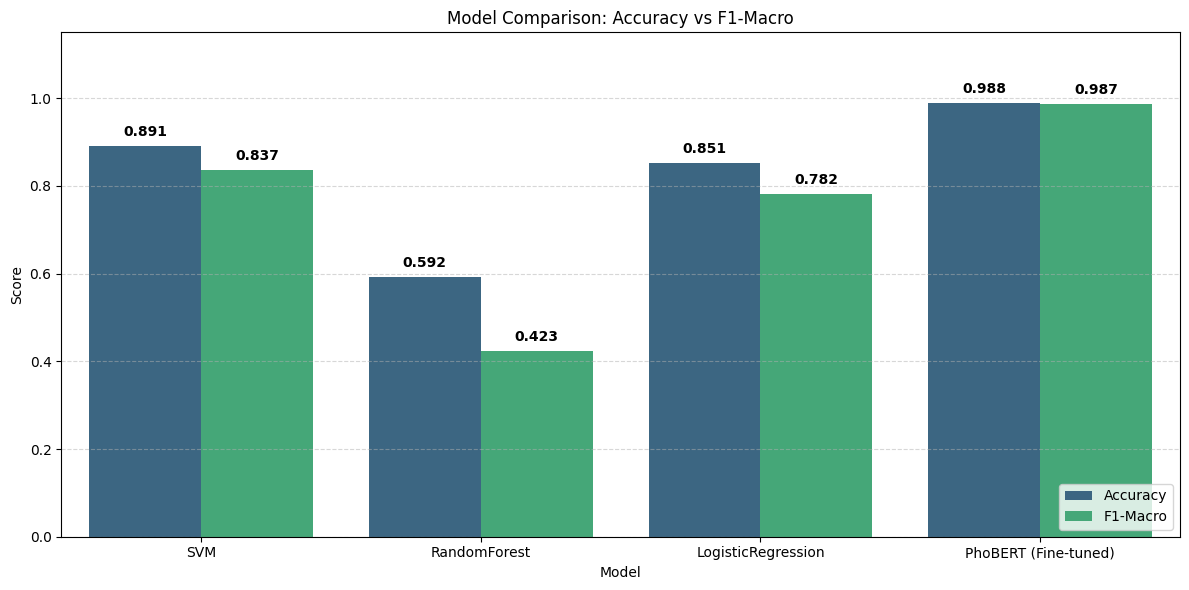

✅ Saved PhoBERT Model.


In [ ]:
print("\n=== FINAL LEADERBOARD ===")
df_res = pd.DataFrame(final_stats)

display(df_res)

df_melt = df_res.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melt, palette="viridis")

plt.title("Model Comparison: Accuracy vs F1-Macro")
plt.ylim(0, 1.15) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')


for p in ax.patches:
    if p.get_height() > 0: 
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

trainer.save_model("final_models/phobert_finetuned")
phobert_tokenizer.save_pretrained("final_models/phobert_finetuned")
print("Saved PhoBERT Model.")

# 7. DEMO PREDICTION & VISUALIZATION

In [ ]:

input_text = "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."
subject_text = "vụ tai nạn" 
object_text = "bị thương"   

print(f" Câu: \"{input_text}\"")
print(f"Quan hệ giữa: [{subject_text}] -> [{object_text}]")
print("-" * 50)


def prepare_input(text, sub, obj):
    sub_start = text.find(sub)
    obj_start = text.find(obj)
    
    if sub_start == -1 or obj_start == -1:
        return None, "Không tìm thấy thực thể trong câu!"
    
    sub_end = sub_start + len(sub)
    obj_end = obj_start + len(obj)
    
    # Chèn marker
    spans = [(sub_start, " [E1] "), (sub_end, " [/E1] "),
             (obj_start, " [E2] "), (obj_end, " [/E2] ")]
    spans.sort(key=lambda x: x[0], reverse=True)
    
    processed_text = text
    for idx, token in spans:
        processed_text = processed_text[:idx] + token + processed_text[idx:]
        
    # Tách từ PyVi
    return ViTokenizer.tokenize(processed_text), None

def get_embedding_for_ml(processed_text):
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    tokenizer.add_special_tokens({'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']})
    base_phobert = AutoModel.from_pretrained("vinai/phobert-base")
    base_phobert.resize_token_embeddings(len(tokenizer))
    base_phobert.to(device).eval()
    
    with torch.no_grad():
        inputs = tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = base_phobert(**inputs)
        
        # Mean Pooling
        mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        mean_emb = sum_emb / sum_mask
        
    return mean_emb.cpu().numpy()

processed_text, error = prepare_input(input_text, subject_text, object_text)

if error:
    print(f"Lỗi: {error}")
else:
    print(f" Text đã xử lý: {processed_text}\n")
    results = []

    # --- NHÓM ML PREDICTION ---
    vector_input = get_embedding_for_ml(processed_text)
    
    # SVM
    pred_svm = svm.predict(vector_input)[0]
    results.append({"Model": "SVM", "Type": "Machine Learning", "Prediction": id2label[pred_svm]})
    
    # Random Forest
    pred_rf = rf.predict(vector_input)[0]
    results.append({"Model": "Random Forest", "Type": "Machine Learning", "Prediction": id2label[pred_rf]})
    
    # Logistic Regression
    pred_lr = lr.predict(vector_input)[0]
    results.append({"Model": "Logistic Regression", "Type": "Machine Learning", "Prediction": id2label[pred_lr]})

    # --- NHÓM DL PREDICTION ---
    # Tokenize input
    inputs_dl = phobert_tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs_dl = {k: v.to(device) for k, v in inputs_dl.items()}
    
    # Predict
    with torch.no_grad():
        outputs = trainer.model(**inputs_dl)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_idx].item()
        
    results.append({
        "Model": "PhoBERT (Fine-tuned)", 
        "Type": "Deep Learning", 
        "Prediction": id2label[pred_idx],
        "Confidence": f"{confidence:.2%}"
    })

    df_results = pd.DataFrame(results)
    def color_prediction(val):
        color = '#d62728' if val == 'NO_RELATION' else '#2ca02c'
        return f'color: {color}; font-weight: bold'

    print("=== KẾT QUẢ DỰ ĐOÁN ===")
    display(df_results.style.applymap(color_prediction, subset=['Prediction']))

 Câu: "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."
Quan hệ giữa: [vụ tai nạn] -> [bị thương]
--------------------------------------------------
 Text đã xử lý: Tại ngã tư cầu giấy Hà_Nội , chiếc xe_máy do anh A điều_khiển đang chở vợ đã va_chạm mạnh với xe_tải đi ngược chiều vào 14h30 chiều ngày 22 / 12 , [ E1 ] vụ tai_nạn [ / E1 ] khiến anh A [ E2 ] bị_thương [ / E2 ] , xe ô tải móp đầu .

=== KẾT QUẢ DỰ ĐOÁN ===


/tmp/ipykernel_47/190365075.py:119: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(df_results.style.applymap(color_prediction, subset=['Prediction']))


,Model,Type,Prediction,Confidence
0,SVM,Machine Learning,HAS_CONSEQUENCE,nan
1,Random Forest,Machine Learning,HAS_CONSEQUENCE,nan
2,Logistic Regression,Machine Learning,HAS_CONSEQUENCE,nan
3,PhoBERT (Fine-tuned),Deep Learning,HAS_CONSEQUENCE,99.98%


# 8. MULTI-RELATION PREDICTION DEMO

In [ ]:


input_text = "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."


test_pairs = [
    ("vụ tai nạn", "ngã tư cầu giấy Hà Nội", "Mong đợi: LOCATED_AT"),
    ("vụ tai nạn", "14h30 chiều ngày 22/12", "Mong đợi: HAPPENED_ON"),
    ("anh A", "xe máy", "Mong đợi: INVOLVED (Driver)"),
    ("vụ tai nạn", "xe tải", "Mong đợi: INVOLVED (Vehicles)"),
    ("anh A", "xe tải", "Mong đợi: INVOLVED (hoặc NO_RELATION)"), 
    ("va chạm", "xe tải", "Mong đợi: INVOLVED (hoặc NO_RELATION)"), 
    ("va chạm", "bị thương", "Mong đợi: HAS_CONSEQUENCED (hoặc NO_RELATION)") 
]

print(f"Câu gốc: \"{input_text}\"")
print("-" * 60)


def prepare_input(text, sub, obj):
    sub_start = text.find(sub)
    obj_start = text.find(obj)
    
    if sub_start == -1 or obj_start == -1:
        return None, f"Không tìm thấy '{sub}' hoặc '{obj}'"
    
    sub_end = sub_start + len(sub)
    obj_end = obj_start + len(obj)

    spans = [(sub_start, " [E1] "), (sub_end, " [/E1] "),
             (obj_start, " [E2] "), (obj_end, " [/E2] ")]
    spans.sort(key=lambda x: x[0], reverse=True)
    
    processed_text = text
    for idx, token in spans:
        processed_text = processed_text[:idx] + token + processed_text[idx:]
        
    return ViTokenizer.tokenize(processed_text), None

def get_ml_vector(processed_text):
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    tokenizer.add_special_tokens({'additional_special_tokens': ['[E1]', '[/E1]', '[E2]', '[/E2]']})
    base_model = AutoModel.from_pretrained("vinai/phobert-base")
    base_model.resize_token_embeddings(len(tokenizer))
    base_model.to(device).eval()
    
    with torch.no_grad():
        inputs = tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = base_model(**inputs)
        
        # Mean Pooling
        mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        mean_emb = sum_emb / sum_mask
        
    return mean_emb.cpu().numpy() # Trả về vector 1D

all_results = []

for sub, obj, note in test_pairs:
    processed_text, error = prepare_input(input_text, sub, obj)
    
    if error:
        print(f"Bỏ qua cặp [{sub}] - [{obj}]: {error}")
        continue
        
    # A. Machine Learning Prediction
    # Reshape (1, -1) vì model ML cần input 2D
    vec = get_ml_vector(processed_text).reshape(1, -1) 
    
    pred_svm = id2label[svm.predict(vec)[0]]
    pred_rf = id2label[rf.predict(vec)[0]]
    
    # B. Deep Learning Prediction (PhoBERT)
    inputs_dl = phobert_tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs_dl = {k: v.to(device) for k, v in inputs_dl.items()}
    
    with torch.no_grad():
        outputs = trainer.model(**inputs_dl)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_idx].item()
        pred_bert = id2label[pred_idx]

    all_results.append({
        "Subject": sub,
        "Object": obj,
        "SVM": pred_svm,
        "RandomForest": pred_rf,
        "PhoBERT (DL)": pred_bert,
        "Confidence (DL)": f"{confidence:.1%}",
        "Note": note
    })

df_final = pd.DataFrame(all_results)

def highlight_cols(val):
    color = '#d62728' if val == 'NO_RELATION' else '#2ca02c' # Đỏ nếu không có quan hệ, Xanh nếu có
    return f'color: {color}; font-weight: bold'

print("\n=== KẾT QUẢ PHÂN TÍCH QUAN HỆ ===")
styled_df = df_final.style.applymap(highlight_cols, subset=['SVM', 'RandomForest', 'PhoBERT (DL)'])
display(styled_df)

Câu gốc: "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."
------------------------------------------------------------

=== KẾT QUẢ PHÂN TÍCH QUAN HỆ ===


/tmp/ipykernel_47/4235113403.py:123: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_final.style.applymap(highlight_cols, subset=['SVM', 'RandomForest', 'PhoBERT (DL)'])


,Subject,Object,SVM,RandomForest,PhoBERT (DL),Confidence (DL),Note
0,vụ tai nạn,ngã tư cầu giấy Hà Nội,LOCATED_AT,HAS_CONSEQUENCE,LOCATED_AT,100.0%,Mong đợi: LOCATED_AT
1,vụ tai nạn,14h30 chiều ngày 22/12,HAPPENED_ON,INVOLVED,HAPPENED_ON,100.0%,Mong đợi: HAPPENED_ON
2,anh A,xe máy,INVOLVED,INVOLVED,INVOLVED,100.0%,Mong đợi: INVOLVED (Driver)
3,vụ tai nạn,xe tải,INVOLVED,INVOLVED,INVOLVED,100.0%,Mong đợi: INVOLVED (Vehicles)
4,anh A,xe tải,INVOLVED,INVOLVED,INVOLVED,100.0%,Mong đợi: INVOLVED (hoặc NO_RELATION)
5,va chạm,xe tải,INVOLVED,INVOLVED,INVOLVED,100.0%,Mong đợi: INVOLVED (hoặc NO_RELATION)
6,va chạm,bị thương,HAS_CONSEQUENCE,INVOLVED,HAS_CONSEQUENCE,100.0%,Mong đợi: HAS_CONSEQUENCED (hoặc NO_RELATION)


# 9. SAVE ALL MODELS & METADATA

In [ ]:
print("--- Starting to save all models ---")

SAVE_DIR = "final_models_complete"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"Created directory: {SAVE_DIR}")

# 2. Lưu Metadata 
metadata = {
    "label2id": label2id,
    "id2label": id2label,
    "valid_schema": VALID_SCHEMA,
    "model_type": "Hybrid (ML + PhoBERT Fine-tuning)"
}
joblib.dump(metadata, f"{SAVE_DIR}/metadata.pkl")
print(f" Saved Metadata.")

# 3. Lưu 3 Model Machine Learning
ml_models_map = {
    "svm_model": svm if 'svm' in globals() else None,
    "rf_model": rf if 'rf' in globals() else None,
    "lr_model": lr if 'lr' in globals() else None
}

for name, model in ml_models_map.items():
    if model is not None:
        path = f"{SAVE_DIR}/{name}.joblib"
        joblib.dump(model, path)
        print(f"Saved ML Model: {path}")
    else:
        print(f"Warning: {name} not found (maybe not trained yet?)")

# 4. Lưu PhoBERT Fine-tuned
if 'trainer' in globals() and 'phobert_tokenizer' in globals():
    phobert_path = f"{SAVE_DIR}/phobert_finetuned"
    print(f"Saving PhoBERT to {phobert_path}...")
    trainer.save_model(phobert_path)
    phobert_tokenizer.save_pretrained(phobert_path)
    
    print(f"Saved PhoBERT Fine-tuned.")
else:
    print(" Warning: Trainer or Tokenizer not found.")

# 5. Nén thành file ZIP (để dễ download từ Kaggle/Colab)
print("\nZipping folder for download...")
shutil.make_archive("all_models", 'zip', SAVE_DIR)
print(f" COMPLETED! Download file 'all_models.zip' to use.")

--- Starting to save all models ---
Created directory: final_models_complete
 Saved Metadata.
Saved ML Model: final_models_complete/svm_model.joblib
Saved ML Model: final_models_complete/rf_model.joblib
Saved ML Model: final_models_complete/lr_model.joblib
Saving PhoBERT to final_models_complete/phobert_finetuned...
Saved PhoBERT Fine-tuned.

Zipping folder for download...
 COMPLETED! Download file 'all_models.zip' to use.
